# Project - First Requirement

## Without capacity constraint

### Include packages.

In [25]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm    # Just to plot distribution of valuations
from scipy import optimize

### The first thing to do is to code the environment.

In [26]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

### In this setting, the environment is responsible for telling the seller about the reward.

In [27]:
class PricingEnvironmentSingleProduct(Environment):
    # buyers' valuation is a normal distribution with a mean of self.mean_valuation and a standard deviation of self.std_valuation.
    def __init__(self, cost, mean_valuation, std_valuation, buyers_per_round):
        self.cost = cost
        self.mean_valuation = mean_valuation
        self.std_valuation = std_valuation
        self.buyers_per_round = buyers_per_round

    def round(self, p_t):
        # calculates the Cumulative Distribution Function (CDF) of a normal distribution.
        prob_buy = 1 - norm.cdf(p_t, loc=self.mean_valuation, scale=self.std_valuation)

        # Number of sales is drawn from a binomial distribution
        num_of_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)

        reward = (p_t - self.cost) * num_of_sales
        return num_of_sales, reward

### Now define the setting...

In [28]:
# --- Global Settings ---

N = 1                     # Number of products (unused in this version)
T = 20000                 # Time horizon (number of rounds)
n_trials = 10             # Number of independent trials for averaging

# --- Pricing Grid and Product Info ---

cost = 2.00                       # Unit production cost
value = 3.00                      # True mean customer valuation
std_valuation = 1.0               # Standard deviation of customer valuations

min_p = 0.0
max_p = int(value * 2)
price_step = 0.5
P = np.linspace(min_p, max_p, int((max_p - min_p) / price_step) + 1)    # Discrete set of prices
K = len(P)                                                              # Number of price options (arms)

assert cost < value , "Cost must be less than value"

# --- Market and Inventory Parameters ---

B = 120000 * N                          # Total inventory available (seller capacity)

# --- Derived Buyer Generation per Round ---

buyers_per_round = 50                   # Number of buyers per round per product
assert buyers_per_round >= 1, "Must have at least one buyer per round"

# --- Other Parameters ---

zoom = 0.001                # Zoom factor for detail plotting
s = 30                      # random seed

### Expected demand and profit using theoretical expectations.

In [29]:
# In our setting, customer valuations are drawn from a normal distribution.
# Given this assumption, we can analytically compute the expected demand at each price p.
# It can be proven that the expected demand is given by: 

def expected_demand(p):
    return np.sum(1 - norm.cdf(p, loc=np.full(buyers_per_round, value), scale=1.0))

# This results in a smooth probability-based estimation of demand for each price p,
# where the probability for a single customer to buy is the tail area of the normal distribution beyond p.

expected_demand_vector = np.array([expected_demand(p) for p in P])
expected_profit_vector = (P - cost) * expected_demand_vector

best_expected_index = np.argmax(expected_profit_vector)
best_expected_price = P[best_expected_index]
best_expected_profit = expected_profit_vector[best_expected_index]

### Let us visualize our setting.

Max expected profit (theoretical): 25.0
...at price: 3.0


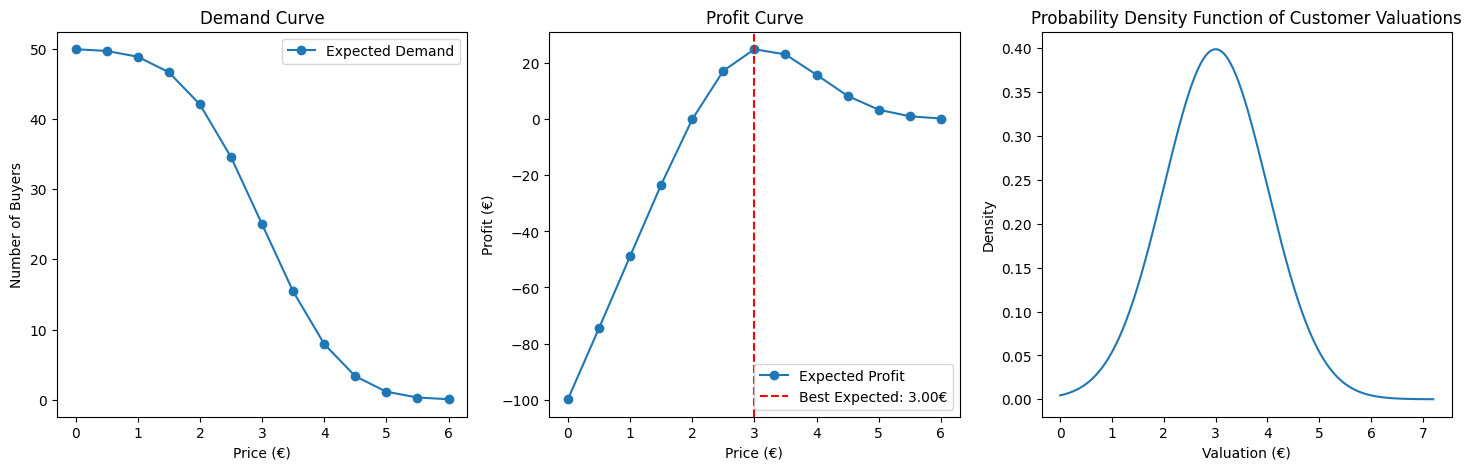

In [30]:
# --- Summary of Results ---

print("Max expected profit (theoretical):", round(best_expected_profit, 2))
print("...at price:", round(best_expected_price, 2))

# --- Plots: Expected vs Realized Demand and Profit ---

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Demand comparison
axs[0].plot(P, expected_demand_vector, label='Expected Demand', marker='o')
axs[0].set_title("Demand Curve")
axs[0].set_xlabel("Price (€)")
axs[0].set_ylabel("Number of Buyers")
axs[0].legend()

# Profit comparison
axs[1].plot(P, expected_profit_vector, label='Expected Profit', marker='o')
axs[1].axvline(best_expected_price, color='r', linestyle='--', label=f"Best Expected: {best_expected_price:.2f}€")
axs[1].set_title("Profit Curve")
axs[1].set_xlabel("Price (€)")
axs[1].set_ylabel("Profit (€)")
axs[1].legend()

# Additional plot for the PDF of customer valuations
x_vals = np.linspace(min_p, max_p * 1.2, 500) # Extend range slightly for visualization
axs[2].plot(x_vals, norm.pdf(x_vals, loc=value, scale=std_valuation))
axs[2].set_title("Probability Density Function of Customer Valuations")
axs[2].set_xlabel("Valuation (€)")
_ = axs[2].set_ylabel("Density")

### How can I interact with this environment? We use Agents.

In [31]:
class Agent:
    def __init__(self):
        pass
    def pull_arm(self):
        pass
    def update(self, r_t):
        pass

### Define the UCB1 Agent.

In [32]:
# If rewards lie in [0, R], you must scale the confidence term by self.range = R maximum possible reward in a round t.
R = ( max(P) - cost ) * buyers_per_round

class UCB1Agent(Agent):
    def __init__(self, range=1):
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < K: # In the first K rounds, we sample each arm once
            self.a_t = self.t
        else:   
            ucbs = self.average_rewards + self.range * np.sqrt( 2 * np.log(T) / self.N_pulls )
            self.a_t = np.argmax(ucbs)
        return self.a_t

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += ( r_t - self.average_rewards[self.a_t] ) / self.N_pulls[self.a_t]
        self.t += 1

### Let's see in which arms the algorithm spends more time.

Expected best price: 3.0


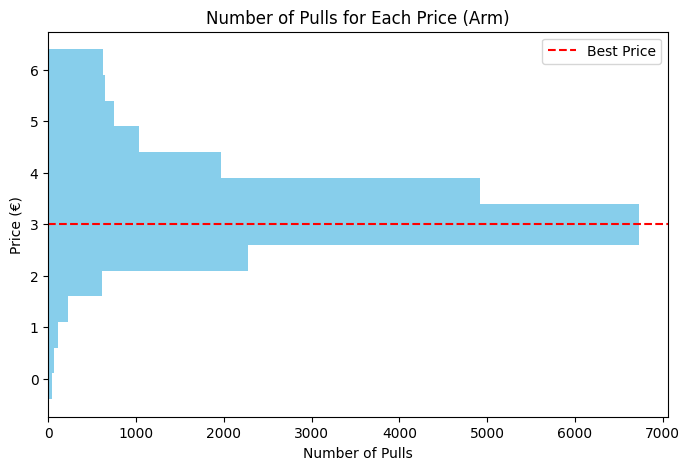

In [33]:
# --- Single run to compare realized rewards ---

# The clairvoyant benchmark in a stochastic environment is the expected reward of the optimal arm.
clairvoyant_expected_rewards = np.repeat(best_expected_profit, T)

# Initialize the stochastic environment
np.random.seed(s)
env = PricingEnvironmentSingleProduct(cost=cost, mean_valuation=value, std_valuation=std_valuation, buyers_per_round=buyers_per_round)

# Run UCB1
ucb_agent = UCB1Agent(range=R)
agent_rewards = np.array([])
pull_counts = np.zeros(K, dtype=int)  # <-- Track number of times each arm is pulled
chosen_arms_history = []

for t in range(T):
    pi_t = ucb_agent.pull_arm()
    p_t = P[pi_t]
    d_t, r_t = env.round(p_t)
    ucb_agent.update(r_t)
    agent_rewards = np.append(agent_rewards, r_t)
    pull_counts[pi_t] += 1
    chosen_arms_history.append(pi_t)

# Get prices instead of arms indexes
chosen_arms_history = np.array(chosen_arms_history)/2

# Compute most played price
most_played_action = np.argmax(pull_counts)
most_played_price = P[most_played_action]

# Compute realized regret
expected_regret = np.cumsum(clairvoyant_expected_rewards - agent_rewards)

print("Expected best price:", round(best_expected_price, 2))

# --- UCB1 Agent ---
plt.figure(figsize=(8, 5))
plt.barh(P, ucb_agent.N_pulls, color='skyblue')
plt.axhline(P[best_expected_index], color='red', linestyle='--', label='Best Price')
plt.xlabel('Number of Pulls')
plt.ylabel('Price (€)')
plt.title('Number of Pulls for Each Price (Arm)')
_ = plt.legend()

Let's quickly check when the algorithm uses each arm over time.

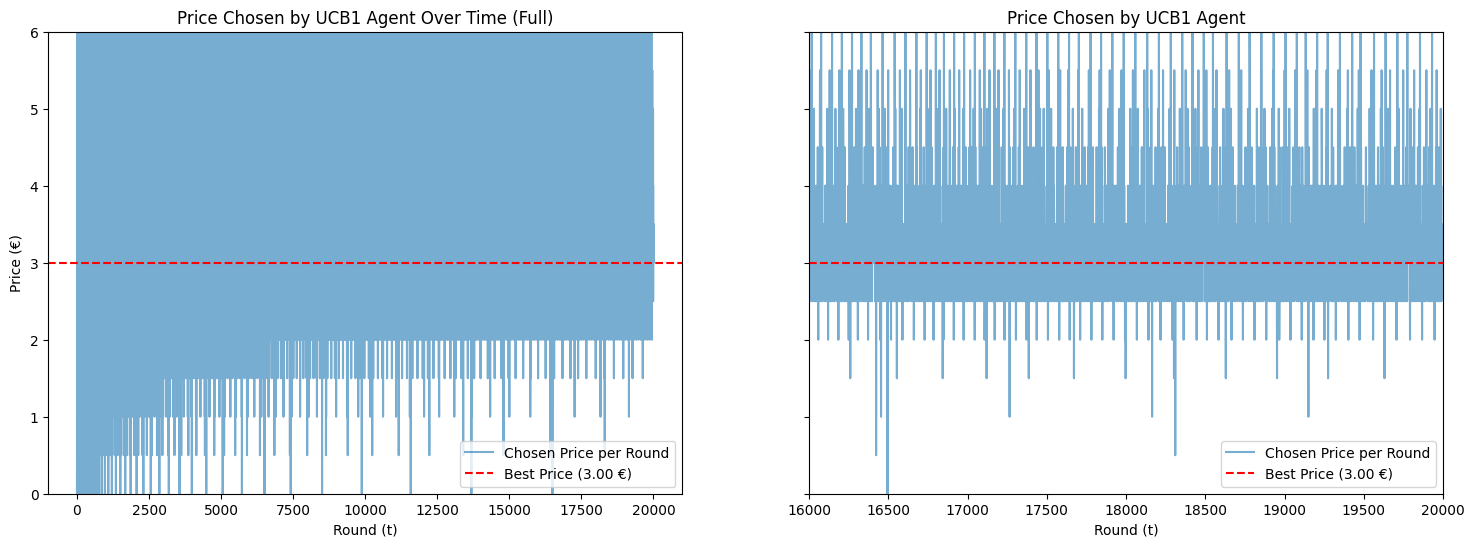

In [34]:
# --- Chosen arm over time: Full and Zoomed-In Plots ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Full plot
ax1.plot(range(T), chosen_arms_history, alpha=0.6, label='Chosen Price per Round')
ax1.axhline(y=best_expected_price, color='red', linestyle='--', label=f'Best Price ({best_expected_price:.2f} €)')
ax1.set_xlabel('Round (t)')
ax1.set_ylabel('Price (€)')
ax1.set_title('Price Chosen by UCB1 Agent Over Time (Full)')
ax1.set_ylim(min(P), max(P))
ax1.legend()

# Zoomed-in plot
zoom_start = int(T * 0.8)
ax2.plot(range(T), chosen_arms_history, alpha=0.6, label='Chosen Price per Round')
ax2.axhline(y=best_expected_price, color='red', linestyle='--', label=f'Best Price ({best_expected_price:.2f} €)')
ax2.set_xlabel('Round (t)')
ax2.set_title('Price Chosen by UCB1 Agent')
ax2.set_xlim(zoom_start, T)
ax2.set_ylim(min(P), max(P))
_ = ax2.legend()

### Pseudo Regret - Estimation


Since it is very complex to compute the theoretical Expected Regret (nor Pseudo) at each round - due to the complex stochasticity in the choice of the action... We estimate it by computing it as the average cumulative regret per round, over many trials. To do this, we use the expected reward of both the clairvoyant and the agent actions, to reduce the variability of the estimation.

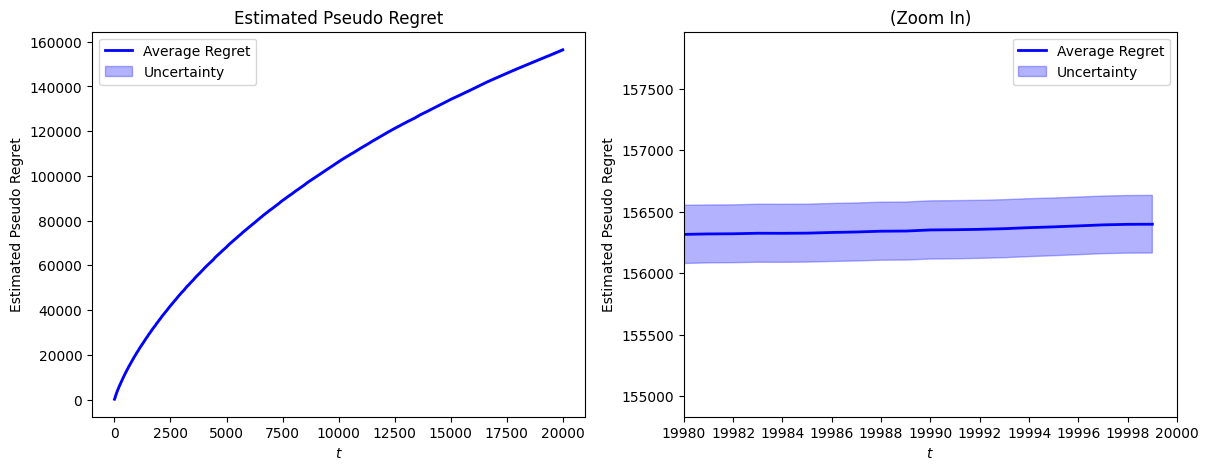

In [35]:
# Compute cumulative regret over multiple trials
regret_per_trial = []
expected_clairvoyant_rewards = np.repeat(best_expected_profit, T) 

for seed in range(n_trials):
    # Initialize the stochastic environment for each trial
    np.random.seed(seed)
    env = PricingEnvironmentSingleProduct(cost=cost, mean_valuation=value, std_valuation=std_valuation, buyers_per_round=buyers_per_round)
    
    # Initialize
    ucb_agent = UCB1Agent(range=R)
    agent_rewards = np.array([])

    # Run UCB1 for T rounds
    for t in range(T):
        pi_t = ucb_agent.pull_arm()
        p_t = P[pi_t]
        d_t, r_t = env.round(p_t)
        ucb_agent.update(r_t)
        agent_rewards = np.append(agent_rewards, r_t)

    # Store cumulative regret for this trial
    cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)
    regret_per_trial.append(cumulative_regret)

# Compute average (and standard deviation) of regret
average_regret = np.array(regret_per_trial).mean(axis=0)
regret_sd = np.array(regret_per_trial).std(axis=0)

# --- Plot regret ---

# Set zoom start time based on the zoom factor
zoom_start_t = max(0, T - max(1, int(T * zoom)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

# Full Plot (now on the left)
ax1.plot(np.arange(T), average_regret, 'b-', linewidth=2, label='Average Regret')
ax1.fill_between(np.arange(T), average_regret - regret_sd / np.sqrt(n_trials), average_regret + regret_sd / np.sqrt(n_trials), alpha=0.3, color='blue', label='Uncertainty')
ax1.set_title('Estimated Pseudo Regret')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Estimated Pseudo Regret')
ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

# Zoom In (now on the right)
ax2.plot(np.arange(T), average_regret, 'b-', linewidth=2, label='Average Regret')
ax2.fill_between(np.arange(T), (average_regret - regret_sd / np.sqrt(n_trials)), (average_regret + regret_sd / np.sqrt(n_trials)), alpha=0.3, color='blue', label='Uncertainty')
ax2.set_xlim(zoom_start_t, T)
ax2.set_ylim(np.max(average_regret) * 0.99, np.max(average_regret) * 1.01)  # Adjust y-limits for better visibility
ax2.set_title('(Zoom In)')
ax2.set_xlabel('$t$')
ax2.set_ylabel('Estimated Pseudo Regret')
ax2.legend()
ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

### How would it behave with full feedback?

Define expert problem environment.

In [36]:
class FullFeedbackPricingEnvironment(PricingEnvironmentSingleProduct):
    def full_feedback_round(self):
        rewards = []
        demands = []
        for p_t in P:
            prob_buy = 1 - norm.cdf(p_t, loc=self.mean_valuation, scale=self.std_valuation)
            num_of_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)
            reward = (p_t - self.cost) * num_of_sales
            rewards.append(reward)
            demands.append(num_of_sales)
        return np.array(demands), np.array(rewards)

Define a greedy agent to compare.

In [37]:
class FollowTheLeaderAgent(Agent):
    def __init__(self):
        self.average_rewards = np.zeros(K)
        self.N_updates = np.zeros(K)
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.a_t = np.argmax(self.average_rewards)
        return self.a_t

    def update(self, reward_vector):
        # Update estimates for all arms using full feedback
        self.N_updates += 1
        self.average_rewards += (reward_vector - self.average_rewards) / self.N_updates
        self.t += 1

Re-define UCB1 to exploit full feedback.

In [38]:
class UCB1FullFeedbackAgent(Agent):
    def __init__(self, reward_range=1):
        self.range = reward_range
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
        self.a_t = None

    def pull_arm(self):
        if self.t < K:
            self.a_t = self.t
        else:
            ucb_values = self.average_rewards + self.range * np.sqrt(2 * np.log(T + 1) / self.N_pulls)
            self.a_t = np.argmax(ucb_values)
        return self.a_t

    def update(self, reward_vector):
        self.t += 1
        for a in range(K):
            self.N_pulls[a] += 1
            self.average_rewards[a] += (reward_vector[a] - self.average_rewards[a]) / self.N_pulls[a]

Run experiment.

In [39]:
# --- UCB1 Full Feedback Run ---

np.random.seed(s)  # Reset random seed for reproducibility
env = FullFeedbackPricingEnvironment(cost, value, std_valuation, buyers_per_round)
ucb_agent = UCB1FullFeedbackAgent(reward_range=R)

ucb_rewards = []
chosen_arms_1 = []

for t in range(T):
    _, rewards = env.full_feedback_round()  # full reward vector
    arm = ucb_agent.pull_arm()
    ucb_agent.update(rewards)
    ucb_rewards.append(rewards[arm])
    chosen_arms_1.append(arm)

ucb_regret = np.cumsum(clairvoyant_expected_rewards - ucb_rewards)

# --- Greedy Agent Run ---

np.random.seed(s)  # Reset random seed for reproducibility
env = FullFeedbackPricingEnvironment(cost, value, std_valuation, buyers_per_round)
greedy_agent = FollowTheLeaderAgent()

chosen_arms = []
greedy_rewards_chosen = []  # rewards from chosen arm only
greedy_rewards_all = []     # full reward vector per round

for t in range(T):
    _, rewards = env.full_feedback_round()
    arm = greedy_agent.pull_arm()
    greedy_agent.update(rewards)

    chosen_arms.append(arm)
    greedy_rewards_chosen.append(rewards[arm])  # scalar reward from chosen arm
    greedy_rewards_all.append(rewards.copy())   # full vector of rewards for all arms

greedy_regret = np.cumsum(clairvoyant_expected_rewards - greedy_rewards_chosen)

Show results.

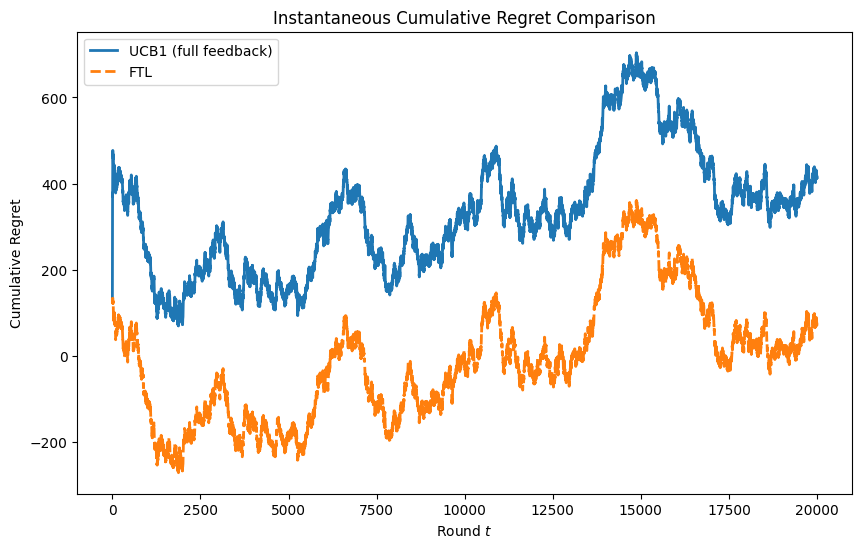

In [40]:
# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(ucb_regret, label='UCB1 (full feedback)', linewidth=2)
plt.plot(greedy_regret, label='FTL', linewidth=2, linestyle='--')
plt.title('Instantaneous Cumulative Regret Comparison')
plt.xlabel('Round $t$')
plt.ylabel('Cumulative Regret')
_ = plt.legend()

Which arms does the greedy approach choose?

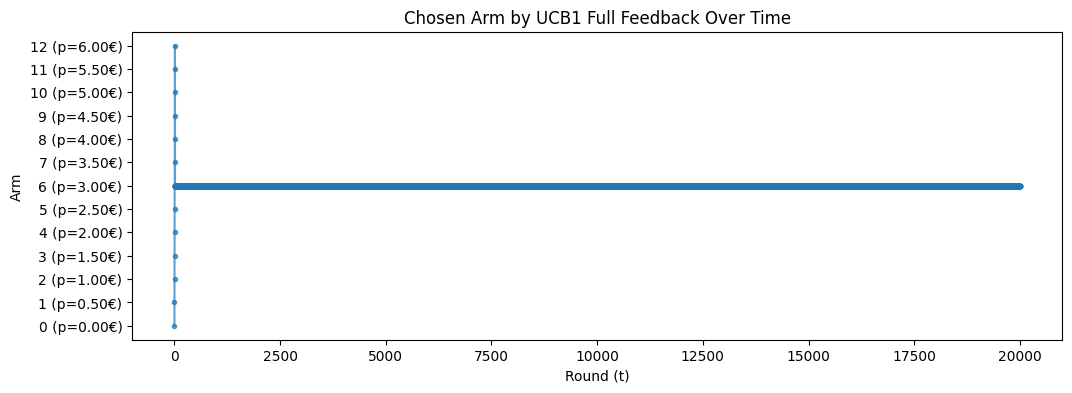

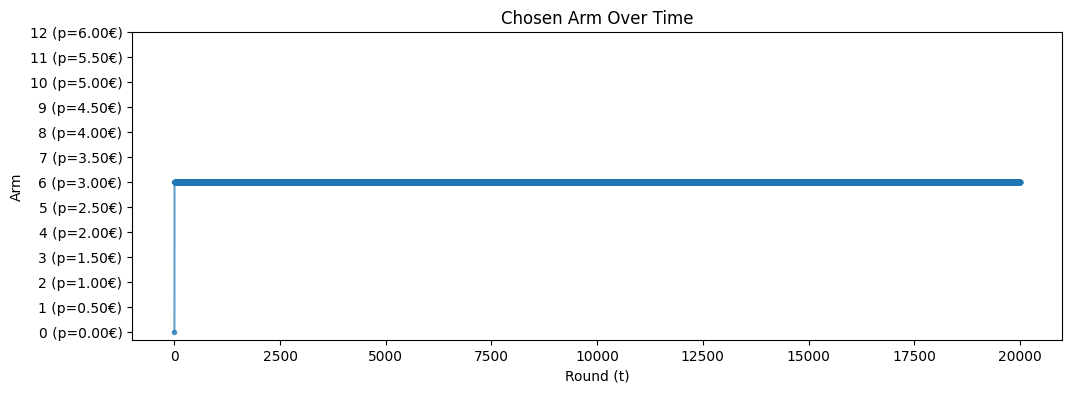

In [41]:
plt.figure(figsize=(12, 4))
plt.plot(chosen_arms_1, marker='o', linestyle='-', markersize=3, alpha=0.7)
plt.xlabel('Round (t)')
plt.ylabel('Arm')
plt.title('Chosen Arm by UCB1 Full Feedback Over Time')
plt.yticks(np.arange(K), [f'{i} (p={p:.2f}€)' for i, p in enumerate(P)])
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(chosen_arms, marker='o', linestyle='-', markersize=3, alpha=0.7)
plt.xlabel('Round (t)')
plt.ylabel('Arm')
plt.title('Chosen Arm Over Time')
_ = plt.yticks(np.arange(K), [f'{i} (p={p:.2f}€)' for i, p in enumerate(P)])

## With capacity constraint

### Let's introduce a maximum capacity for the seller.

In [42]:
# --- Agent ---
class UCBLikeInventoryAgent(Agent):
    def __init__(self, B, range=1):
        self.range = range              # Confidence scaling factor
        self.a_t = None                 # Last chosen arm index
        self.avg_f = np.zeros(K)        # Average reward per arm
        self.avg_c = np.zeros(K)        # Average consumption per arm
        self.N_pulls = np.zeros(K)      # Number of pulls per arm
        self.inventory = B              # Total inventory
        self.rho = B / T                # Average allowed consumption per round
        self.t = 0                      # Current round

    # We may want to track the gamma distribution over t, so we add the option
    def pull_arm(self, return_gamma=False):
        if self.inventory < 1:
            self.a_t = None
            return (None, None) if return_gamma else None

        if self.t < K:
            self.a_t = self.t
            gamma = np.zeros(K)
            gamma[self.a_t] = 1.0
        else:
            f_ucbs = self.avg_f + self.range * np.sqrt(2 * np.log(T) / self.N_pulls)
            c_lcbs = self.avg_c - self.range * np.sqrt(2 * np.log(T) / self.N_pulls)
            gamma = self.compute_opt(f_ucbs, c_lcbs)
            self.a_t = np.random.choice(K, p=gamma)

        return (self.a_t, gamma) if return_gamma else self.a_t

    def compute_opt(self, f_ucbs, c_lcbs):
        # If all LCBs are zero or negative, fallback to greedy
        if np.sum(c_lcbs <= np.zeros(K)) == K:
            gamma = np.zeros(K)
            gamma[np.argmax(f_ucbs)] = 1
            return gamma
        
        # Solve the linear program
        c = -f_ucbs
        A_ub = [c_lcbs]
        b_ub = [self.rho]
        A_eq = [np.ones(K)]
        b_eq = [1]
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1), method='highs')
        gamma = res.x
        return gamma

    def update(self, f_t, c_t):
        self.N_pulls[self.a_t] += 1
        self.avg_f[self.a_t] += (f_t - self.avg_f[self.a_t]) / self.N_pulls[self.a_t]
        self.avg_c[self.a_t] += (c_t - self.avg_c[self.a_t]) / self.N_pulls[self.a_t]
        self.inventory -= c_t
        self.t += 1

### Compute the regret for our new algorithm.

Run the experiment.

In [43]:
# Compute cumulative regret over multiple trials
regret_per_trial = []
inventory_per_trial = []
expected_clairvoyant_rewards = np.repeat(best_expected_profit, T)

for seed in range(n_trials):
    
    # Create environment using new valuations
    np.random.seed(seed)
    env = PricingEnvironmentSingleProduct(cost=cost, mean_valuation=value, std_valuation=std_valuation, buyers_per_round=buyers_per_round)
    
    # Initialize
    ucb_like_agent = UCBLikeInventoryAgent(B=B, range=1)
    agent_rewards = []
    inventory_trace = []

    # Run UCB1 for T rounds
    for t in range(T):

        pi_t = ucb_like_agent.pull_arm()

        # If the inventory is exhausted, we can break the loop
        if pi_t is None:
            agent_rewards.extend([0] * (T - t))
            inventory_trace.extend([ucb_like_agent.inventory] * (T - t))
            break
        
        # Otherwise, proceed 
        p_t = P[pi_t]
        d_t, r_t = env.round(p_t)
        ucb_like_agent.update(f_t=r_t, c_t=d_t)
        agent_rewards.append(r_t)
        inventory_trace.append(ucb_like_agent.inventory)

    # Store cumulative regret for this trial
    cumulative_regret = np.cumsum(expected_clairvoyant_rewards - np.array(agent_rewards))
    regret_per_trial.append(cumulative_regret)
    inventory_per_trial.append(inventory_trace)

# --- Compute stats ---
average_regret = np.mean(regret_per_trial, axis=0)
regret_sd = np.std(regret_per_trial, axis=0)

average_inventory = np.mean(inventory_per_trial, axis=0)
inventory_used = B - average_inventory  # cumulative consumption

Plot.

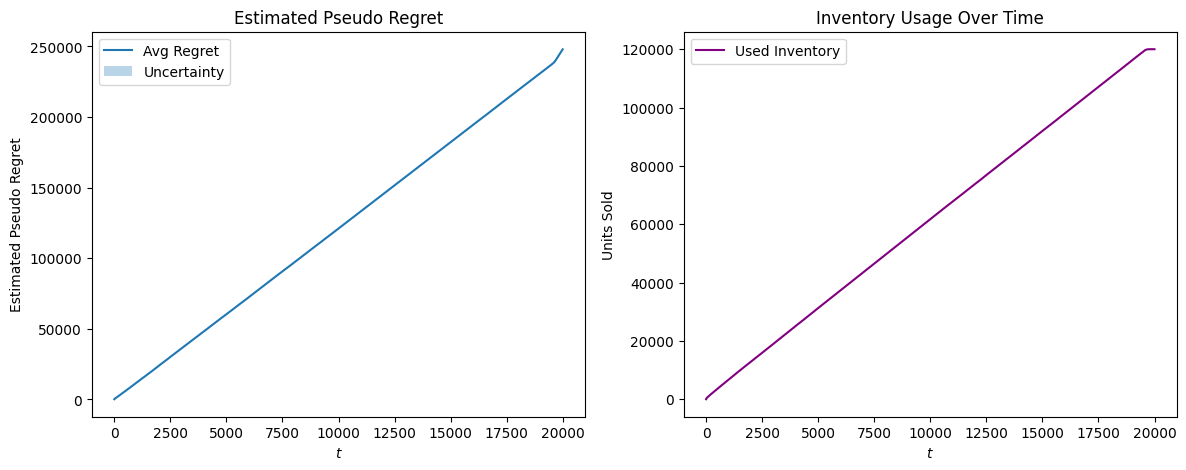

In [44]:
# --- Plot: Regret and Budget Usage ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Regret plot
ax1.plot(np.arange(T), average_regret, label='Avg Regret')
ax1.fill_between(np.arange(T), average_regret - regret_sd / np.sqrt(n_trials), average_regret + regret_sd / np.sqrt(n_trials), alpha=0.3, label='Uncertainty')
ax1.set_title('Estimated Pseudo Regret')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Estimated Pseudo Regret')
ax1.legend()

# Inventory usage plot
ax2.plot(np.arange(T), inventory_used, label='Used Inventory', color='purple')
ax2.set_title('Inventory Usage Over Time')
ax2.set_xlabel('$t$')
ax2.set_ylabel('Units Sold')
_ = ax2.legend()

### What?? Linear regret?!

From the previous regret plot, it seems that the regret is not as good as we would expect, given the theoretical guarantees.

The reason in this case is that we are comparing an algorithm playing with a max capacity - thus looking for a mix which lets it save items until the very latest rounds - against a clairvoyant which can keep selling as many items as wanted at each round.

In fact, the algorithm - due to the constraint - does NEVER play the optimal arm, implying linear regret.

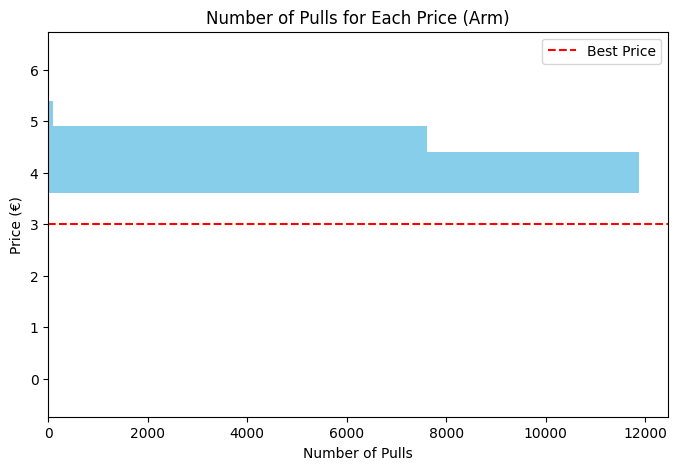

In [45]:
# --- Chosen arms on the alst trial ---
plt.figure(figsize=(8, 5))
plt.barh(P, ucb_like_agent.N_pulls, color='skyblue') 
plt.axhline(P[best_expected_index], color='red', linestyle='--', label='Best Price') 
plt.xlabel('Number of Pulls')
plt.ylabel('Price (€)')
plt.title('Number of Pulls for Each Price (Arm)')
_ = plt.legend()

Which is good! Because we would end the budget soon and obtain worse results. Here the algorithm, "decides to sell less" to sell enough - and at better price!.

In the following analysis, we will prove that no fixed-arm clairvoyant actually wins over our algorithm in the given setting of a fixed maximum capacity. We then propose a new clairvoyant, that is, a mixed optimal strategy clairvoyant which chooses the best mixed-policy such that the expected cost is at most $\rho$, along with a fixed-arm clairvoyant which accounts for the overall budget constraint.

In [47]:
# --- Clairvoyant fixed price under inventory constraint ---

expected_profits = []
expected_units = []

# Compute expected total profit for each price, under the inventory constraint B
for p, d in zip(P, expected_demand_vector):
    total_units = d * T                         # total units that could be sold at price p (if unlimited inventory)
    capped_units = min(total_units, B)          # actual units that can be sold given the inventory constraint
    profit = (p - cost) * capped_units          # expected total profit at this price
    expected_profits.append(profit)
    expected_units.append(capped_units)

expected_profits = np.array(expected_profits)
expected_units = np.array(expected_units)

# Select the best fixed price (clairvoyant choice under constraint)
best_index = np.argmax(expected_profits)
best_price = P[best_index]
best_profit = expected_profits[best_index]

# Print results for the fixed-price clairvoyant
print(f"--- Fixed Price Clairvoyant ---")
print(f"Best price: {best_price:.2f}")
print(f"Expected total profit: {best_profit:.2f}")

# Compute reward vector over T rounds for this fixed price
price_fixed = best_price
demand_fixed = expected_demand_vector[best_index]
reward_per_round_fixed = (price_fixed - cost) * demand_fixed

max_rounds_full = int(B // demand_fixed)        # how many full rounds can be executed
remaining_budget = B - (max_rounds_full * demand_fixed)
partial_reward = (price_fixed - cost) * remaining_budget if remaining_budget > 0 else 0

clairvoyant_rewards_fixed = np.zeros(T)
clairvoyant_rewards_fixed[:max_rounds_full] = reward_per_round_fixed
if max_rounds_full < T:
    clairvoyant_rewards_fixed[max_rounds_full] = partial_reward

# --- Clairvoyant mixed strategy under capacity constraint ---

expected_rewards = (P - cost) * expected_demand_vector
expected_costs = expected_demand_vector
rho = B / T                 # average budget per round

# Solve LP to find optimal randomized (mixed) pricing strategy under capacity constraint
c = -expected_rewards       # we maximize reward → minimize negative reward
A_ub = [expected_costs]     # constraint: average cost per round <= rho
b_ub = [rho]
A_eq = [np.ones(K)]         # probabilities must sum to 1
b_eq = [1]

res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1), method='highs')
gamma_star = res.x          # optimal price distribution (clairvoyant mixed strategy)
clairvoyant_mixed_reward_per_round = np.dot(gamma_star, expected_rewards)
clairvoyant_mixed_total_reward = clairvoyant_mixed_reward_per_round * T
clairvoyant_rewards_mixed = np.full(T, clairvoyant_mixed_reward_per_round)

# Print results for the mixed-strategy clairvoyant
print(f"\n--- Mixed Strategy Clairvoyant ---")
print(f"Optimal mixed strategy: {np.round(gamma_star, 2)}")
print(f"Expected total reward: {clairvoyant_mixed_total_reward:.2f}")

# --- Learnt vs Clairvoyant Rewards ---

f_ucbs = ucb_like_agent.avg_f + ucb_like_agent.range * np.sqrt(2 * np.log(T) / ucb_like_agent.N_pulls)
c_lcbs = ucb_like_agent.avg_c - ucb_like_agent.range * np.sqrt(2 * np.log(T) / ucb_like_agent.N_pulls)
gamma = ucb_like_agent.compute_opt(f_ucbs, c_lcbs)

print(f"\n--- Learnt (dynamic) mixed strategy ---")
print(f"Optimal mixed strategy: {np.round(gamma, 2)}")
print(f"Total reward: {np.array(agent_rewards).sum():.2f}")


--- Fixed Price Clairvoyant ---
Best price: 4.00
Expected total profit: 240000.00

--- Mixed Strategy Clairvoyant ---
Optimal mixed strategy: [0.   0.   0.   0.   0.   0.   0.   0.   0.58 0.42 0.   0.   0.  ]
Expected total reward: 254058.27

--- Learnt (dynamic) mixed strategy ---
Optimal mixed strategy: [0.   0.   0.   0.   0.   0.   0.   0.   0.59 0.41 0.   0.   0.  ]
Total reward: 251963.50


### Visualize.

Run the experiment.

In [49]:
# --- Run algorithm and compute regret against both baselines ---

regret_vs_fixed = []
regret_vs_mixed = []
inventory_trace_list = []

for seed in range(n_trials):

    # Initialize the stochastic environment for each trial
    np.random.seed(seed)
    env = PricingEnvironmentSingleProduct(cost=cost, mean_valuation=value, std_valuation=std_valuation, buyers_per_round=buyers_per_round)

    ucb_like_agent = UCBLikeInventoryAgent(B=B, range=1)
    rewards = []
    inventory_trace = []

    # Run UCB-like agent for T rounds
    for t in range(T):
        pi_t = ucb_like_agent.pull_arm()

        if pi_t is None:
            rewards.extend([0] * (T - t))
            inventory_trace.extend([ucb_like_agent.inventory] * (T - t))
            break

        price = P[pi_t]
        demand, reward = env.round(price)
        ucb_like_agent.update(f_t=reward, c_t=demand)
        rewards.append(reward)
        inventory_trace.append(ucb_like_agent.inventory)

    # Store cumulative regret for this trial
    rewards = np.array(rewards)
    regret_vs_fixed.append(np.cumsum(clairvoyant_rewards_fixed - rewards))
    regret_vs_mixed.append(np.cumsum(clairvoyant_rewards_mixed - rewards))
    inventory_trace_list.append(inventory_trace)

# --- Compute stats ---

avg_regret_fixed = np.mean(regret_vs_fixed, axis=0)
std_regret_fixed = np.std(regret_vs_fixed, axis=0)

avg_regret_mixed = np.mean(regret_vs_mixed, axis=0)
std_regret_mixed = np.std(regret_vs_mixed, axis=0)

avg_inventory_used = B - np.mean(inventory_trace_list, axis=0)

Anyway, the regret in relative terms is not very high.

Final value of the regret vs fixed clairvoyant: -12005.050000005154
Final value of the regret vs mixed clairvoyant: 2053.2193624673105


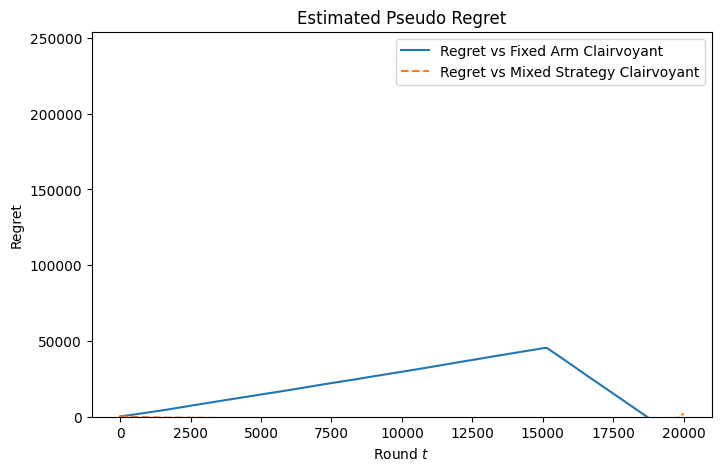

In [50]:
# --- Plots ---

plt.figure(figsize=(8, 5))

# Plot regret vs fixed clairvoyant
plt.plot(avg_regret_fixed, label='Regret vs Fixed Arm Clairvoyant')
plt.fill_between(np.arange(T), avg_regret_fixed - std_regret_fixed / np.sqrt(n_trials), avg_regret_fixed + std_regret_fixed / np.sqrt(n_trials), alpha=0.2)

# Plot regret vs mixed clairvoyant
plt.plot(avg_regret_mixed, label='Regret vs Mixed Strategy Clairvoyant', linestyle='--')
plt.fill_between(np.arange(T), avg_regret_mixed - std_regret_mixed / np.sqrt(n_trials), avg_regret_mixed + std_regret_mixed / np.sqrt(n_trials), alpha=0.2)

print("Final value of the regret vs fixed clairvoyant:", avg_regret_fixed[-1])
print("Final value of the regret vs mixed clairvoyant:", avg_regret_mixed[-1])

# Styling
plt.title("Estimated Pseudo Regret")
plt.ylim(0, clairvoyant_mixed_total_reward)  # Adjust y-limits for better visibility
plt.xlabel("Round $t$")
plt.ylabel("Regret")
_ = plt.legend()